In [14]:
import argparse
#import psycopg2
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import scipy.signal as sg
from allensdk.core.nwb_data_set import NwbDataSet
from allensdk.core.cell_types_cache import CellTypesCache
import pandas as pd
%matplotlib inline

In [15]:
cells_df=np.load('showcase_df.h5')
PCA_df = pd.load('PCA_showcase_df.h5')
#ctc = CellTypesCache(manifest_file='s:\cell_types\manifest.json')

In [2]:
#create pandas dataframe of specimens that have passed QC from the IVSCC log
cells_df =pd.read_csv('speclist.csv')
#generate a custom report in LIMS 'ivscc data status' and save the report
#create another dataframe from that report
LIMS_df = pd.read_csv('custom_report.csv')

In [3]:
#build up all the necessary columns in the cells dataframe
columns = ['Noise_sweeps','depol_sweeps','hyper_sweeps','ss_sweep','ls_sweep','ramp_sweep','full_name','nwb_path','specimen_id','Cre+','Transgenic_Line','ephys_result_id','dendrite_type','depol_threshold', 'hyper_threshold', 'ss_threshold', 'ls_threshold','ramp_threshold_sweep','ls2_sweep']
for i in columns:
    cells_df[i] = None

In [4]:
#create a list to index through
specimen_list = list(cells_df['Labtrax_ID'])

In [5]:
#transfer data from LIMS dataframe to cell dataframe only for cells that have passed QC
for i in range(len(LIMS_df)):
    try:
        j = specimen_list.index(LIMS_df['specimen_name'][i][-15:-3])
        cells_df['Transgenic_Line'][j] = LIMS_df['transgenic_driver_line'][i]
        cells_df['dendrite_type'][j] = LIMS_df['dendrite_type_tag'][i]
        cells_df['Cre+'][j] = LIMS_df['cre_reporter_positive'][i]
        cells_df['ephys_result_id'][j] = LIMS_df['ephys_result_id'][i]
    except ValueError:
        pass

In [6]:
def LinuxtoWindow(Linuxpath):
    SplitLinux = Linuxpath.split('/')
    #I should be able to link to \\titan, but I can't figure it out, so I mapped //titan/cns to y:    
    WindowsP = os.path.join('y:/','mousecelltypes',SplitLinux[4],SplitLinux[5],'')
    #WindowsP = os.path.join('\\titan','cns','mousecelltypes',SplitLinux[4],SplitLinux[5],'')    
    return (WindowsP)

In [7]:
#pull sweep data directly from LIMS
for specimen in range(len(cells_df)):
    conn = psycopg2.connect('host=limsdb2 dbname=lims2 user=limsreader password=limsro')
    cur = conn.cursor()
    spec_name =  cells_df['Labtrax_ID'][specimen].strip() + '.01'
    cur.execute("SELECT s.name, s.ephys_roi_result_id, s.id FROM specimens s WHERE s.name LIKE %s", ('%' + spec_name,))
    result = cur.fetchone()
    if result is None:
        print "Could not find specimen result for " + spec_name + ". Skipping..."
        #return None
    cells_df['full_name'][specimen] = result[0]
    # print "EphysRoiResult: " + str(result[1])
    specimen_name = result[0]
    ephys_roi_result_id = result[1]
    specimen_id = result[2]
    cells_df['specimen_id'][specimen] = specimen_id
    
    cur.execute("SELECT f.filename, f.storage_directory FROM well_known_files f \
                 WHERE f.attachable_type = 'EphysRoiResult' AND f.attachable_id = %s AND f.filename LIKE '%%nwb'", 
                 (ephys_roi_result_id,))
    result = cur.fetchone()

    if result is None:
        print "Could not find orca or nwb file for " + spec_name + ". Skipping..."
        cells_df['nwb_path'][specimen] = None
    WinP = LinuxtoWindow(result[1])
    if result[0][-16:] == 'uncompressed.nwb':
        cells_df['nwb_path'][specimen] = WinP + result[0][:-17]+'.nwb'
    else:
        cells_df['nwb_path'][specimen] = WinP + result[0]
    
    stim_type = ['%%C1RP25PR1S%%','%%C1SSFINEST%%','%%C1LSFINEST%%','%%SEED%%','%%C2SSHM60FN%%','%%C2SSHM80FN%%']
    df_names = ['ramp_sweep','ss_sweep','ls_sweep','Noise_sweeps','depol_sweeps','hyper_sweeps']
    
    for i in range(len(stim_type)):
        cur.execute("SELECT sw.sweep_number FROM ephys_sweeps sw JOIN ephys_stimuli stim \
                    ON stim.id = sw.ephys_stimulus_id\
                    WHERE sw.specimen_id = %s AND stim.description LIKE %s AND sw.workflow_state SIMILAR TO '%%pass%%'", 
                    (specimen_id,stim_type[i],))
        sweep_list = [s[0] for s in cur.fetchall()]

        if not sweep_list:
            cells_df[df_names[i]][specimen] = None
        elif sweep_list[0] is None:
            cells_df[df_names[i]][specimen] = None
        else:
            sweep_list.sort()
            cells_df[df_names[i]][specimen] = sweep_list

In [8]:
def find_threshold(column,i):
    ds =NwbDataSet(cells_df['nwb_path'][i])
    if cells_df[column][i] == None:
        return None
    else:
        sweep_amp = []
        threshold_spike = None
        for j in cells_df[column][i]:
            sweep = ds.get_sweep(j)
            spike_times = ds.get_spike_times(j)
            if len(spike_times) >0:
                if threshold_spike == None:
                    threshold_spike = j
                else:
                    if max(sweep['stimulus']) < max(ds.get_sweep(threshold_spike)['stimulus']):
                        threshold_spike = j
        return threshold_spike

In [112]:
cells_df.head()

,Labtrax_ID,Noise_sweeps,depol_sweeps,hyper_sweeps,ss_sweep,ls_sweep,ramp_sweep,full_name,nwb_path,specimen_id,Cre+,Transgenic_Line,ephys_result_id,dendrite_type,depol_threshold,hyper_threshold,ss_threshold,ls_threshold,ramp_threshold_sweep,ls2_sweep
0,165865.05.02,"[37, 38, 39, 40, 41]","[95, 97, 98, 99, 100]","[85, 86, 87, 88, 89, 90, 91, 92]","[11, 12, 13, 14, 15, 16, 17, 18]","[44, 45, 46]","[4, 5, 6]",Sst-IRES-Cre;Ai14-165865.05.02.01,y:/mousecelltypes\prod251\Ephys_Specimen_Roi_p...,464212183,t,Sst-IRES-Cre,464212181,aspiny,97,88,12,45,4,None
1,165865.03.01,"[37, 38, 39, 40, 41, 42]",None,None,"[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]","[35, 36, 44, 45]","[4, 5, 6]",Sst-IRES-Cre;Ai14-165865.03.01.01,y:/mousecelltypes\prod251\Ephys_Specimen_Roi_p...,464198958,t,Sst-IRES-Cre,464198956,aspiny,None,None,14,35,4,35
2,165171.03.01,[71],None,None,"[17, 18, 19, 20, 21, 22, 23, 24, 25]",[82],"[4, 5]",Pvalb-IRES-Cre;Ai14-165171.03.01.01,y:/mousecelltypes\prod115\Ephys_Specimen_Roi_p...,313862373,t,Pvalb-IRES-Cre,313862370,aspiny,None,None,17,82,4,None
3,165171.03.02,"[49, 50, 51, 52, 53]","[111, 112, 113, 114, 115, 116, 117, 118, 119]","[103, 104, 105, 106]","[14, 15, 16, 17, 18, 19, 67, 100, 101, 102]","[46, 47]","[4, 5, 6]",Pvalb-IRES-Cre;Ai14-165171.03.02.01,y:/mousecelltypes\prod251\Ephys_Specimen_Roi_p...,464326041,f,Pvalb-IRES-Cre,464326039,aspiny,114,103,14,47,4,47
4,165172.06.02,"[37, 38, 39, 40, 41, 42]",None,None,[10],[35],"[0, 1]",Pvalb-IRES-Cre;Ai14-165172.06.02.01,y:/mousecelltypes\prod251\Ephys_Specimen_Roi_p...,464326095,t,Pvalb-IRES-Cre,464326093,aspiny,None,None,10,None,0,None


In [12]:
columns = ['depol_sweeps', 'hyper_sweeps', 'ss_sweep', 'ls_sweep']
new_columns = ['depol_threshold', 'hyper_threshold', 'ss_threshold', 'ls_threshold']
for i in range(len(cells_df)):
    for j in range(len(columns)):
        cells_df[new_columns[j]][i] = find_threshold(columns[j],i)

In [13]:
for i in range(len(cells_df)):
    ds =NwbDataSet(cells_df['nwb_path'][i])
    if cells_df['ramp_sweep'][i] != None:
        for j in cells_df['ramp_sweep'][i]:
            if cells_df['ramp_threshold_sweep'][i] == None:
                sweep = ds.get_sweep(j)
                spike_times = ds.get_spike_times(j)
                if len(spike_times) > 0:
                    cells_df['ramp_threshold_sweep'][i] = j
    if cells_df['ls_threshold'][i] != None:
        sweep = ds.get_sweep(cells_df['ls_threshold'][i])
        spike_times = ds.get_spike_times(cells_df['ls_threshold'][i])
        if len(spike_times) > 1:
            cells_df['ls2_sweep'][i] = cells_df['ls_threshold'][i]

In [108]:
len(cells_df)#.head()

1961

In [16]:
ss_array = np.load('ss_threshold_raw.npy')
ls_array = np.load('ls_threshold_raw.npy')
rp_array = np.load('ramp_threshold_raw.npy')

In [33]:
ss_ls_array = ss_array - ls_array
ls_rp_array = ls_array - rp_array
rp_ss_array = rp_array - ss_array
for i in range(len(ss_ls_array)):
    ss_ls_array[i] = ss_ls_array[i]+(-ss_ls_array[i,0])
    ls_rp_array[i] = ls_rp_array[i]+(-ls_rp_array[i,0])
    rp_ss_array[i] = rp_ss_array[i]+(-rp_ss_array[i,0])

In [34]:
for i in range(len(ss_array)):
    ss_array[i] = ss_array[i]+(-ss_array[i,0])
    ls_array[i] = ls_array[i]+(-ls_array[i,0])
    rp_array[i] = rp_array[i]+(-rp_array[i,0])

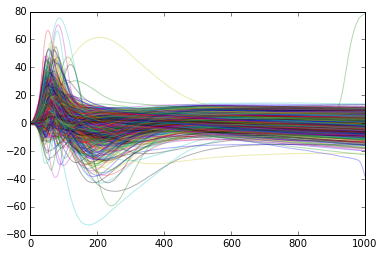

In [26]:
plt.plot(ss_ls_array.T,alpha = .3)

In [19]:
print ss_ls_array[0,0]

-0.968753814697


In [29]:
np.save('ss_ls_array.npy',ss_ls_array)
np.save('ls_rp_array.npy',ls_rp_array)
np.save('rp_ss_array.npy',rp_ss_array)

In [32]:
depol_array = np.load('depol_threshold.npy')
hyper_array = np.load('hyper_threshold.npy')

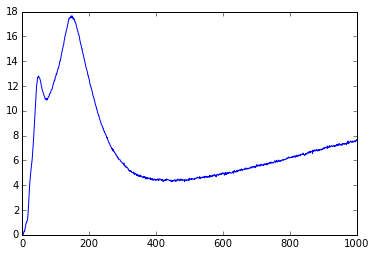

In [35]:
plt.plot(dep_hyp_array[0].T)

In [34]:
dep_hyp_array = depol_array - hyper_array
for i in range(len(dep_hyp_array)):
    dep_hyp_array[i] = dep_hyp_array[i]+(-dep_hyp_array[i,0])

In [36]:
np.save('dep_hyp_array.npy',dep_hyp_array)

In [37]:
np.shape(dep_hyp_array)

(113L, 1000L)

In [3]:
from sklearn.decomposition import PCA
import seaborn

In [17]:
data = ss_array
#ata = ls_array
#data = rp_array
#ata = ss_ls_array
#ata = ls_rp_array
#ata = rp_ss_array
#data= dep_hyp_array
#data = [data1,data2,data3,data4,data5,data6]

In [18]:
# initialized and run decomposition
pca = PCA(10)
pca.fit(data)
decomp = pca.fit_transform(data)
sigma = np.sqrt(pca.explained_variance_)

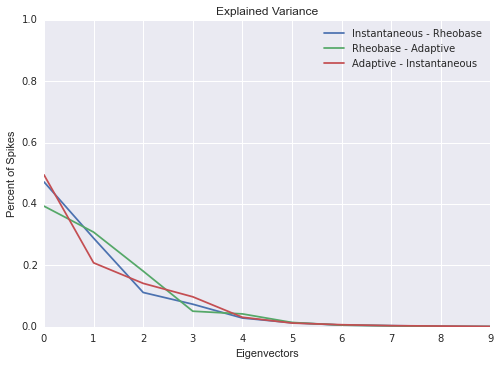

In [217]:
# initialized and run decomposition
pca = PCA(10)
labels = ['Instantaneous','Rheobase','Adaptive','Instantaneous - Rheobase','Rheobase - Adaptive','Adaptive - Instantaneous']
for i in range(3,6):
    pca.fit(data[i])
    decomp = pca.fit_transform(data[i])
    sigma = np.sqrt(pca.explained_variance_)
    plt.plot(pca.explained_variance_ratio_,label = labels[i])
    plt.title('Explained Variance')
    plt.ylim(0,1)
    plt.ylabel('Percent of Spikes')
    plt.xlabel('Eigenvectors')
    plt.legend()
    plt.savefig('explained variance.png')

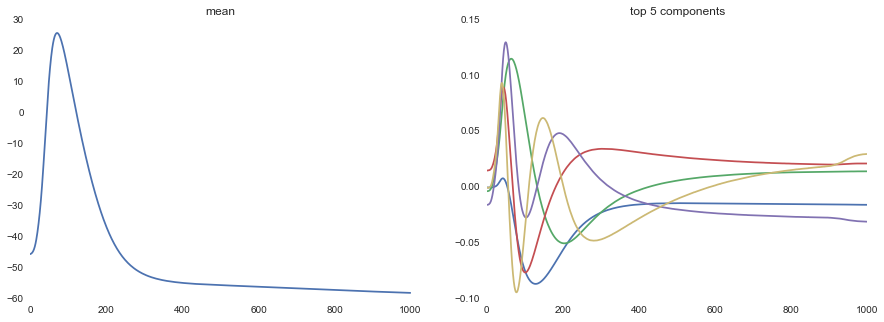

In [19]:
# plot mean and first 5 components
f,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.set_title('mean')
ax2.set_title('top 5 components')
ax1.plot(pca.mean_)
ax2.plot(pca.components_[0:5].T)
plt.savefig('PCA_graph_1.png')

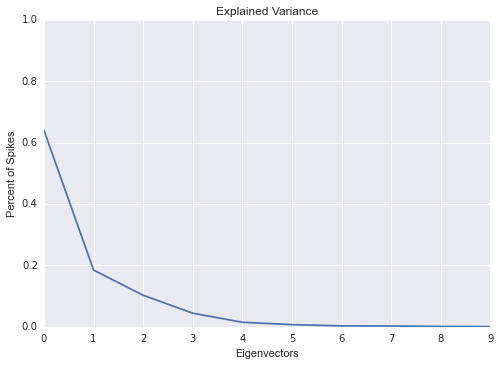

In [350]:
plt.plot(pca.explained_variance_ratio_)
plt.title('Explained Variance')
plt.ylim(0,1)
plt.ylabel('Percent of Spikes')
plt.xlabel('Eigenvectors')
plt.savefig('variance1.png')

In [43]:
specimen = []
cre_line = []

for i in range(len(cells_df)):
    if cells_df['ss_threshold'][i] != None and cells_df['ls_threshold'][i] != None and cells_df['ramp_threshold_sweep'][i] != None:
        specimen.append(cells_df['specimen_id'][i])
        cre_line.append(cells_df['Transgenic_Line'][i])

In [50]:
#pd.DataFrame(zip(specimen,cre_line), columns=[specimen.name, cre_line.name])
PCA_df = pd.DataFrame(specimen,columns = ['specimen'])
PCA_df['Transgenic_Line'] = cre_line

In [51]:
exp_lookup = [e['specimen'] for idx,e in PCA_df.iterrows()]

# Change for every spike type

In [86]:
# add top pca components to the cells dataframe
ncomp = 10
for c in range(ncomp):
    PCA_df['ephys_rp_%02d' % c] = np.nan
    cells_df['ephys_rp_%02d' % c] = np.nan
start_label = 'ephys_rp_%02d' % 0
end_label = 'ephys_rp_%02d' % (ncomp-1)

In [87]:
for e in enumerate(exp_lookup) :
    PCA_df.ix[e, start_label:end_label] = np.divide(decomp[idx,0:ncomp],sigma[0:ncomp])

In [88]:
for f in range(len(PCA_df)-1):
    for i in range(ncomp):
        PCA_df['ephys_rp_%02d' % i][f] = np.divide(decomp[f,i],sigma[i])
        
    

In [71]:
np.shape(sigma)

(10L,)

In [89]:
PCA_df.head()

,specimen,Transgenic_Line,ephys_ls_rp_00,ephys_ls_rp_01,ephys_ls_rp_02,ephys_ls_rp_03,ephys_ls_rp_04,ephys_ls_rp_05,ephys_ls_rp_06,ephys_ls_rp_07,...,ephys_rp_00,ephys_rp_01,ephys_rp_02,ephys_rp_03,ephys_rp_04,ephys_rp_05,ephys_rp_06,ephys_rp_07,ephys_rp_08,ephys_rp_09
0,464212183,Sst-IRES-Cre,-0.514964,1.343235,1.455783,1.716785,-0.342920,0.413004,-0.692401,0.754740,...,-0.483064,1.189709,1.869183,0.666350,1.444145,-0.237908,0.427660,-0.820039,1.181177,-1.490421
1,464198958,Sst-IRES-Cre,-0.744139,0.758558,-0.961296,0.390121,0.505910,-0.091946,-0.852222,-0.302693,...,-1.633336,1.614504,3.396787,-2.626350,0.951345,-2.885841,3.479673,-1.087692,0.692795,-2.065721
2,313862373,Pvalb-IRES-Cre,-1.830629,-3.630018,-0.261396,0.509423,-0.136016,-2.531429,-0.473741,1.270034,...,1.508735,0.463641,1.443266,0.430837,-0.551979,0.240156,0.432701,-0.404721,-0.385881,-0.892629
3,464326041,Pvalb-IRES-Cre,-0.082710,0.480780,-0.180700,-0.174716,-0.207417,-0.374873,-0.338654,0.204186,...,1.368558,-0.542301,0.236141,-1.390121,-1.036264,0.091148,0.146108,-0.794445,-0.353939,-1.131175
4,313861608,Pvalb-IRES-Cre,-0.752351,-2.952523,-0.194894,-1.592041,0.626414,0.749319,-0.700953,0.003127,...,1.679520,-0.106039,-0.267704,0.168873,-0.188983,-1.211845,-0.173588,-0.337397,0.519669,-1.266566


In [341]:
PCA_df.save('PCA_showcase_df.h5')

C:\Anaconda\lib\site-packages\pandas\core\generic.py:968: FutureWarning: save is deprecated, use to_pickle
  warnings.warn("save is deprecated, use to_pickle", FutureWarning)


In [4]:
PCA_df = pd.load('PCA_showcase_df.h5')

In [20]:
def scatter_with_labels(x,y,label,colors) :
    plt.figure(figsize=(9,9))
    for dtype, color in colors:
        masked = PCA_df[PCA_df[label] == dtype]
        plt.scatter(masked[x], masked[y], color=color, label=dtype)
    plt.legend(loc='upper right')
    plt.ylabel(y)
    plt.xlabel(x)
    plt.savefig('scatter.png')

In [21]:
# map some colors to cre-lines
cre_lines = [
'Rorb-IRES2-Cre',
'Scnn1a-Tg2-Cre',
'Scnn1a-Tg3-Cre',
'Nr5a1-Cre',
'Rbp4-Cre_KL100',
'Ntsr1-Cre',
'Sst-IRES-Cre',
'Pvalb-IRES-Cre',
'Htr3a-Cre_NO152',
'Gad2-IRES-Cre']
cre_colors = [
'darksage',
'green',
'mediumaquamarine',
'c',
'dodgerblue',
'blue',
'magenta',
'firebrick',
'r']
type_colors = [
'r',
'r',
'r',
'r',
'r',
'k',
'k',
'k',
'k']

In [7]:
# map some colors to cre-lines
clusters = [
0,
1,
2]
cluster_colors = [
'b',
'g',
'm']

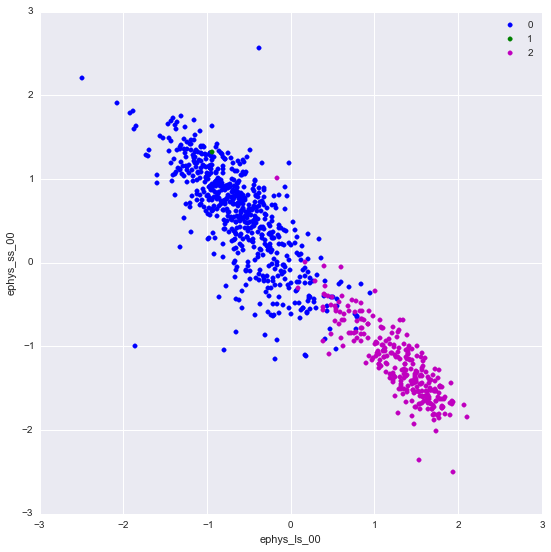

In [13]:
scatter_with_labels('ephys_ls_00','ephys_ss_00','cluster', zip(clusters,cluster_colors))

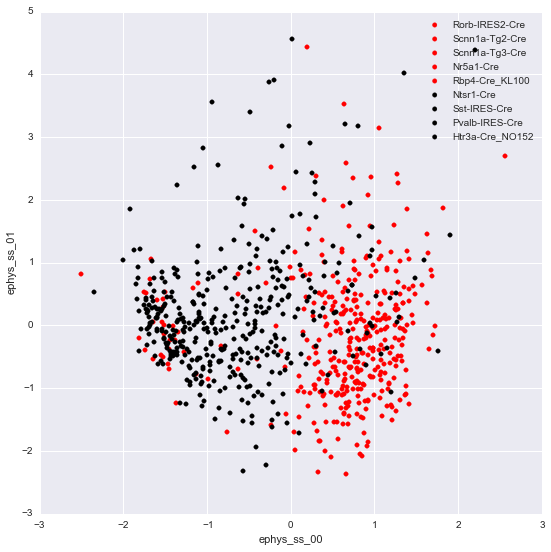

In [12]:
scatter_with_labels('ephys_ss_00','ephys_ss_01','Transgenic_Line', zip(cre_lines,type_colors))

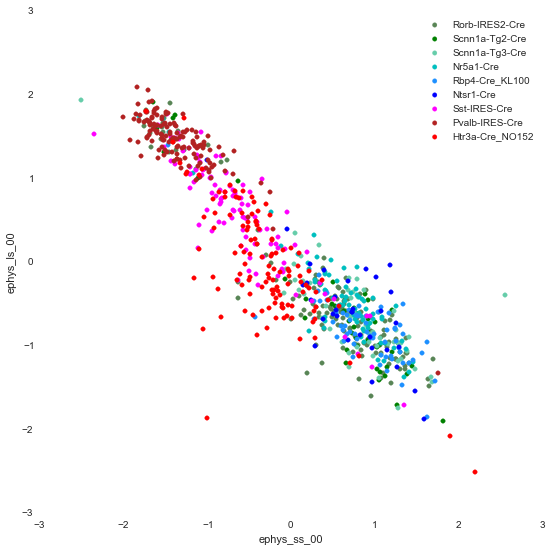

In [23]:
scatter_with_labels('ephys_ss_00','ephys_ls_00','Transgenic_Line', zip(cre_lines,cre_colors))

In [336]:
cre_lines = np.unique(cre_line)
#plt.hist([np.array(cre_line)],5,histtype = 'bar')
#plt.xlabel('Slice Health Rating')
#plt.ylabel('Number of Slices')
#plt.title('Tissue Prep Slice Quailty')
#plt.legend()
#plt.savefig('slice_prep.png')

In [10]:
import seaborn

In [343]:
cre_lines = ['Rorb-IRES2-Cre',
'Scnn1a-Tg2-Cre',
'Scnn1a-Tg3-Cre',
'Nr5a1-Cre',
'Rbp4-Cre_KL100',
'Ntsr1-Cre',
'Sst-IRES-Cre',
'Pvalb-IRES-Cre',
'Htr3a-Cre_NO152',
'Gad2-IRES-Cre',
 'Slc17a6-IRES-Cre']

In [259]:
cre_lines_num = []
cre_lines = list(cre_lines)
for i in cre_line:
    try:
        cre_lines_num.append(cre_lines.index(i))
    except ValueError:
        pass

In [253]:
cre_lines_num


[11,
 11,
 5,
 5,
 5,
 8,
 7,
 7,
 3,
 3,
 9,
 5,
 7,
 8,
 5,
 5,
 5,
 3,
 11,
 4,
 11,
 1,
 1,
 9,
 7,
 11,
 11,
 8,
 6,
 2,
 2,
 2,
 7,
 5,
 5,
 5,
 5,
 5,
 8,
 8,
 8,
 8,
 3,
 3,
 3,
 3,
 9,
 9,
 5,
 5,
 1,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 11,
 9,
 9,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 4,
 6,
 6,
 4,
 4,
 4,
 4,
 11,
 11,
 7,
 11,
 11,
 7,
 2,
 2,
 2,
 11,
 11,
 11,
 11,
 11,
 5,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 5,
 7,
 7,
 8,
 3,
 3,
 3,
 11,
 9,
 9,
 9,
 9,
 9,
 3,
 3,
 3,
 7,
 7,
 11,
 11,
 10,
 10,
 2,
 5,
 2,
 2,
 11,
 7,
 7,
 7,
 5,
 8,
 8,
 5,
 7,
 2,
 6,
 7,
 11,
 7,
 7,
 7,
 2,
 2,
 5,
 2,
 2,
 8,
 7,
 7,
 11,
 11,
 11,
 11,
 11,
 8,
 8,
 8,
 2,
 2,
 2,
 11,
 11,
 11,
 11,
 11,
 11,
 7,
 7,
 7,
 7,
 5,
 5,
 5,
 8,
 3,
 3,
 3,
 3,
 3,
 3,
 9,
 5,
 5,
 5,
 5,
 5,
 9,
 9,
 1,
 1,
 3,
 3,
 2,
 2,
 2,
 7,
 7,
 7,
 7,
 7,
 11,
 9,
 9,
 6,
 6,
 4,
 4,
 4,
 4,
 11,
 11,
 11,
 7,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 11,
 11,
 6,
 3,
 11,
 3,
 11,
 5,
 2,
 2,
 2,
 8,
 8,
 7,
 5,
 5,
 5,
 5,
 7,
 7,
 8

In [120]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3)

In [132]:
PCA_df

,specimen,Transgenic_Line,ephys_ls_rp_00,ephys_ls_rp_01,ephys_ls_rp_02,ephys_ls_rp_03,ephys_ls_rp_04,ephys_ls_rp_05,ephys_ls_rp_06,ephys_ls_rp_07,...,ephys_rp_01,ephys_rp_02,ephys_rp_03,ephys_rp_04,ephys_rp_05,ephys_rp_06,ephys_rp_07,ephys_rp_08,ephys_rp_09,cluster
0,464212183,Sst-IRES-Cre,-0.514964,1.343235,1.455783,1.716785,-0.342920,0.413004,-0.692401,0.754740,...,1.189709,1.869183,0.666350,1.444145,-0.237908,0.427660,-0.820039,1.181177,-1.490421,0
1,464198958,Sst-IRES-Cre,-0.744139,0.758558,-0.961296,0.390121,0.505910,-0.091946,-0.852222,-0.302693,...,1.614504,3.396787,-2.626350,0.951345,-2.885841,3.479673,-1.087692,0.692795,-2.065721,0
2,313862373,Pvalb-IRES-Cre,-1.830629,-3.630018,-0.261396,0.509423,-0.136016,-2.531429,-0.473741,1.270034,...,0.463641,1.443266,0.430837,-0.551979,0.240156,0.432701,-0.404721,-0.385881,-0.892629,2
3,464326041,Pvalb-IRES-Cre,-0.082710,0.480780,-0.180700,-0.174716,-0.207417,-0.374873,-0.338654,0.204186,...,-0.542301,0.236141,-1.390121,-1.036264,0.091148,0.146108,-0.794445,-0.353939,-1.131175,2
4,313861608,Pvalb-IRES-Cre,-0.752351,-2.952523,-0.194894,-1.592041,0.626414,0.749319,-0.700953,0.003127,...,-0.106039,-0.267704,0.168873,-0.188983,-1.211845,-0.173588,-0.337397,0.519669,-1.266566,2
5,313862022,Scnn1a-Tg2-Cre,0.089997,0.015138,-0.005175,0.311693,0.294780,-0.275887,0.055853,0.330367,...,2.471889,-1.262098,-0.949224,-3.285682,0.724447,1.802795,1.339237,4.205433,-6.135953,0
6,314642645,Rorb-IRES2-Cre,0.787842,0.319125,-0.452082,0.156511,-0.539251,-0.243555,-0.581888,0.149619,...,-0.581359,0.309719,-0.849853,-0.020263,0.047939,-0.160301,-0.090729,-0.860534,-1.041083,0
7,314822529,Rorb-IRES2-Cre,0.304420,1.088629,-0.076179,-0.467835,-0.218942,-0.152787,0.194212,0.138927,...,-0.015001,-0.676179,0.815370,-0.232341,0.332508,-0.623154,0.146726,0.120324,1.028334,0
8,318733871,Nr5a1-Cre,-0.067650,-0.269271,-0.436265,-0.026368,-0.309463,0.379032,-0.581883,0.552031,...,0.654247,1.211990,0.152497,-0.274444,0.092772,-0.491760,-0.226906,0.937465,0.636716,0
9,318808427,Nr5a1-Cre,-0.160073,-0.667052,-0.372006,0.666911,0.587718,-0.559396,0.281711,-0.213179,...,-0.366847,1.154632,-0.919274,0.072150,0.903041,-0.540069,-0.052726,-0.095193,0.776929,0


In [23]:
PCA_df['ephys_ss_09'][0]

nan

In [90]:
PCA_df.columns[2:]

cluster_array = PCA_df.as_matrix(columns=PCA_df.columns[2:])

In [25]:
cluster_array = cluster_array[:20]

In [94]:
cluster_array[894]

IndexError: index 894 is out of bounds for axis 0 with size 894

In [121]:
print model.fit(cluster_array)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances=True, random_state=None, tol=0.0001,
    verbose=0)


In [122]:
np.shape(model.fit_transform(cluster_array))

(894L, 3L)

In [128]:
model.predict(cluster_array)[2]

2

In [98]:
model.transform(cluster_array)

array([[  7.22160368,   8.34182141],
       [ 13.46503027,  14.45233427],
       [  9.8750871 ,   8.00254811],
       ..., 
       [  5.05231467,   6.99472403],
       [  5.492704  ,   7.47039018],
       [  5.492704  ,   7.47039018]])

In [60]:
#http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#example-cluster-plot-kmeans-silhouette-analysis-py

In [131]:
PCA_df.save('PCA_showcase_df.h5')

C:\Anaconda\lib\site-packages\pandas\core\generic.py:968: FutureWarning: save is deprecated, use to_pickle
  warnings.warn("save is deprecated, use to_pickle", FutureWarning)


In [16]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


In [31]:
silhouette_avg = silhouette_score(cluster_array,model, model.fit_predict(cluster_array))

ValueError: Number of labels is 1 but should be more than 2and less than n_samples - 1

In [99]:
range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10]

('For n_clusters =', 2, 'The average silhouette_score is :', 0.11456797793677613)


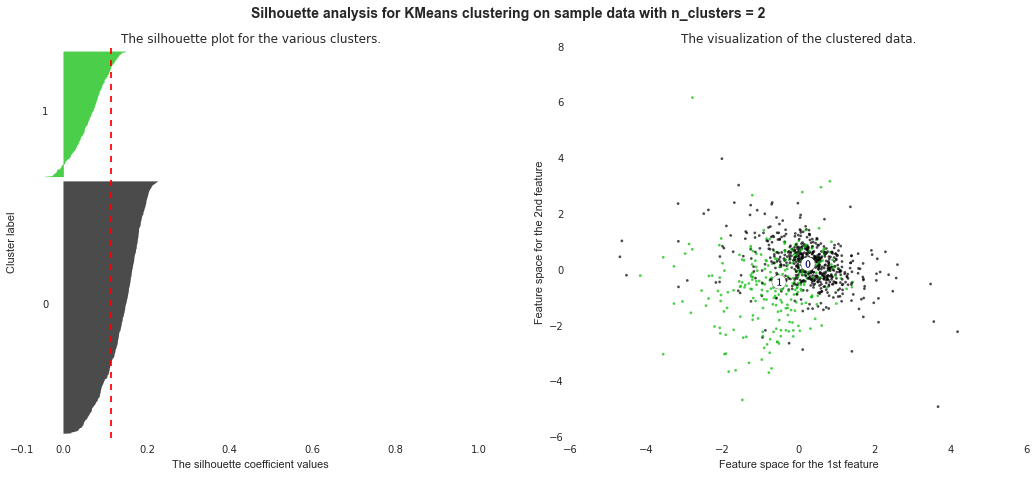

('For n_clusters =', 3, 'The average silhouette_score is :', 0.10355011636433725)


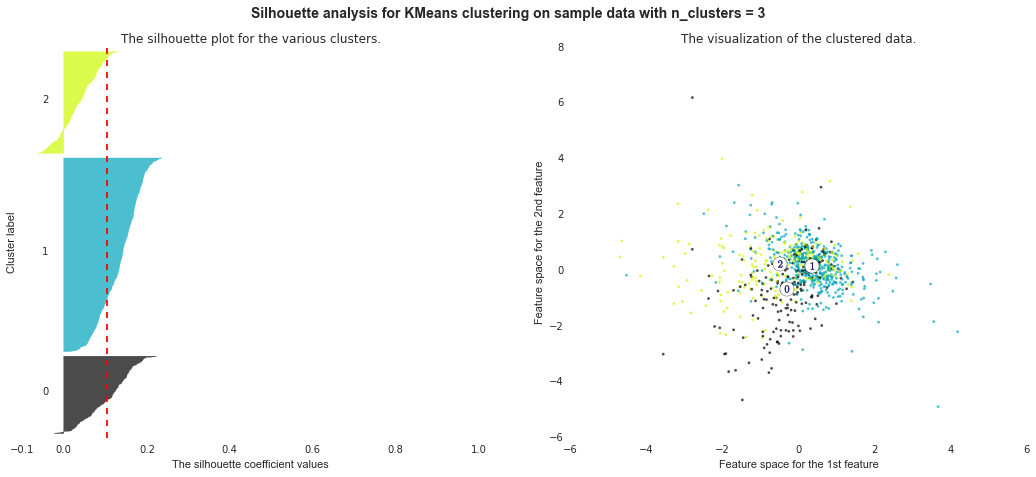

('For n_clusters =', 4, 'The average silhouette_score is :', 0.084087533557380911)


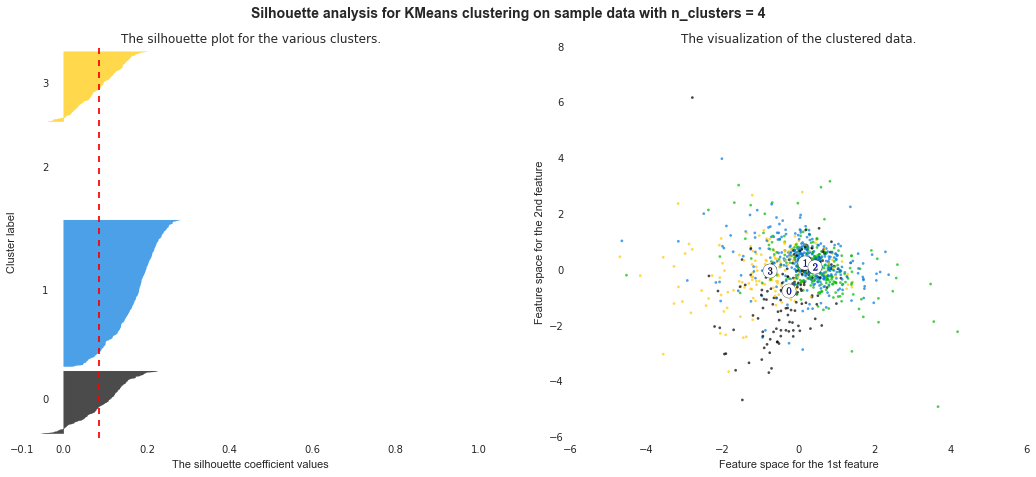

('For n_clusters =', 5, 'The average silhouette_score is :', 0.094443718316425618)


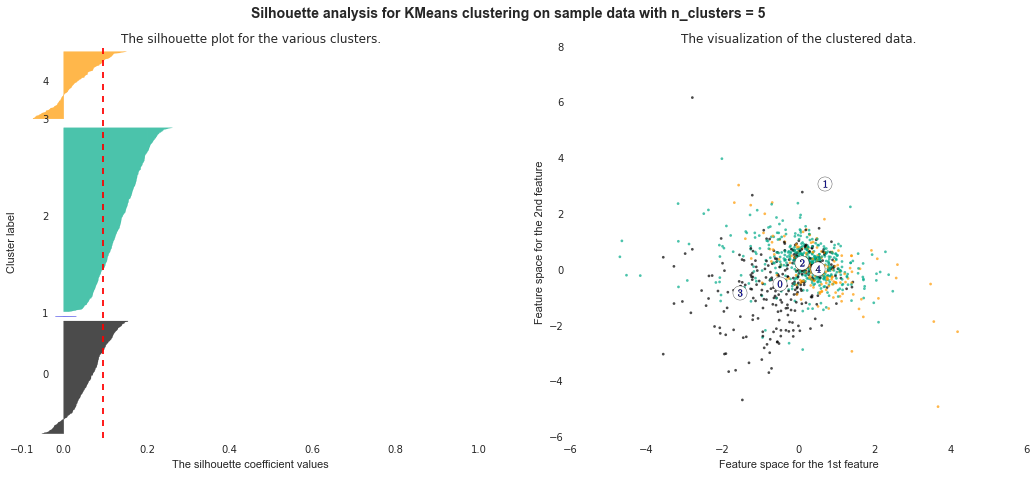

('For n_clusters =', 6, 'The average silhouette_score is :', 0.093579521463489787)


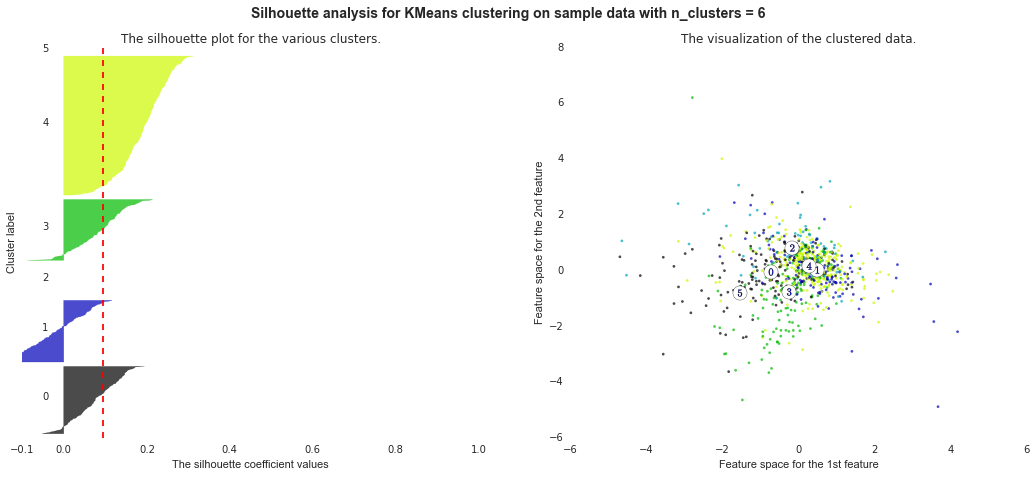

('For n_clusters =', 7, 'The average silhouette_score is :', 0.074362864351435659)


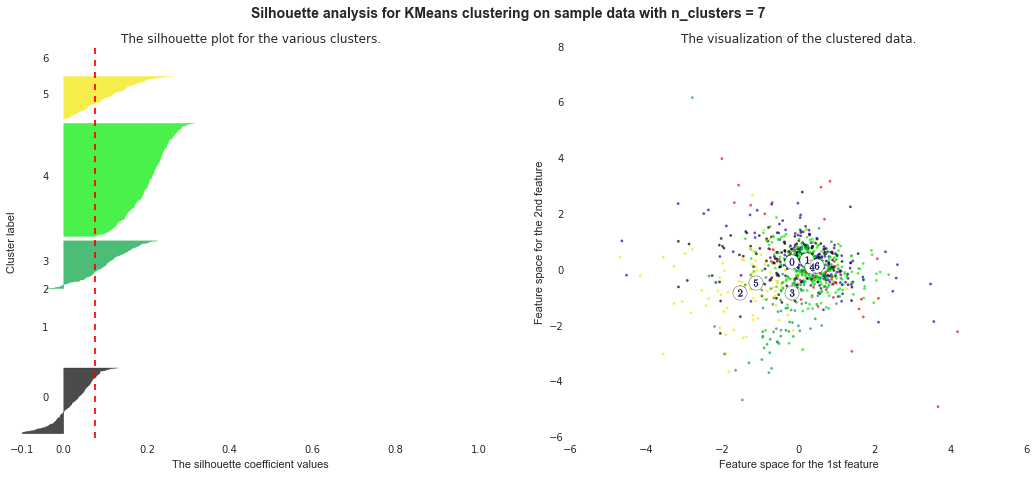

('For n_clusters =', 8, 'The average silhouette_score is :', 0.070823419236981391)


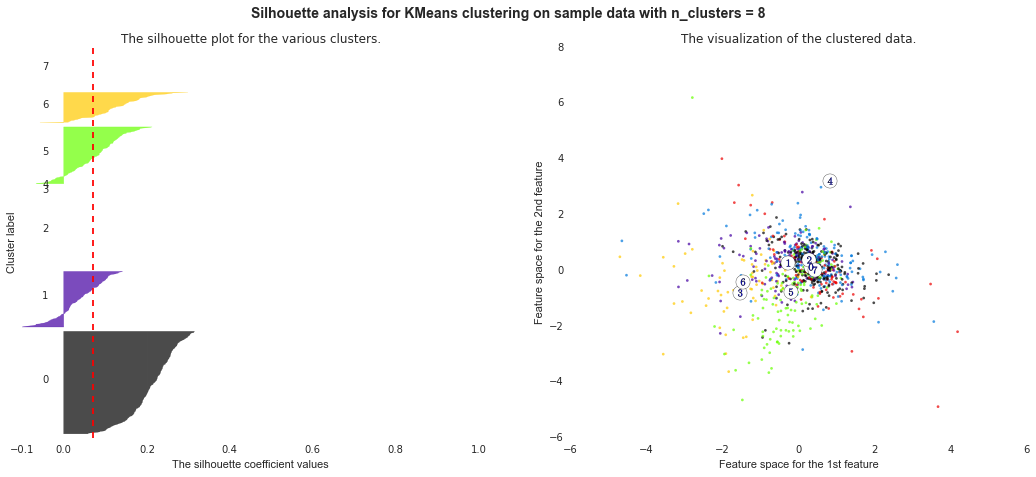

('For n_clusters =', 9, 'The average silhouette_score is :', 0.066891499811715716)


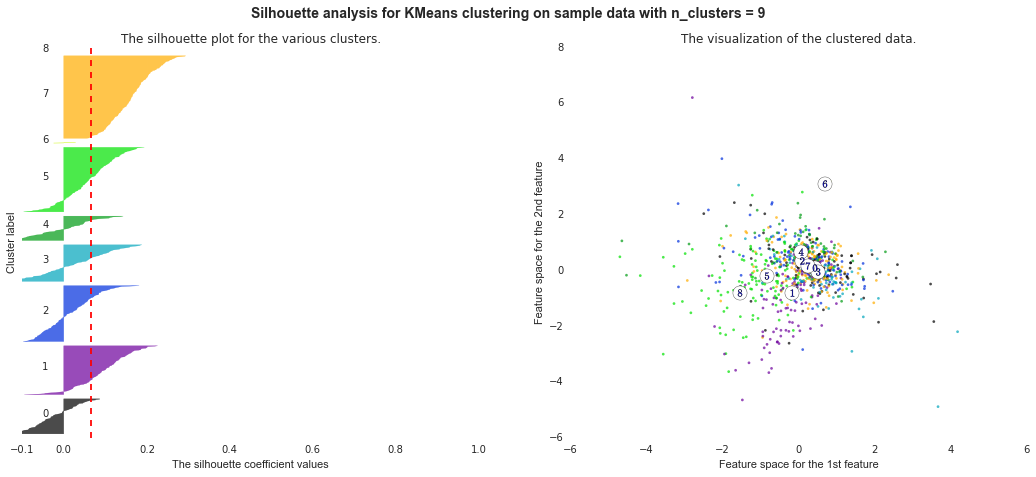

('For n_clusters =', 10, 'The average silhouette_score is :', 0.07003300569056696)


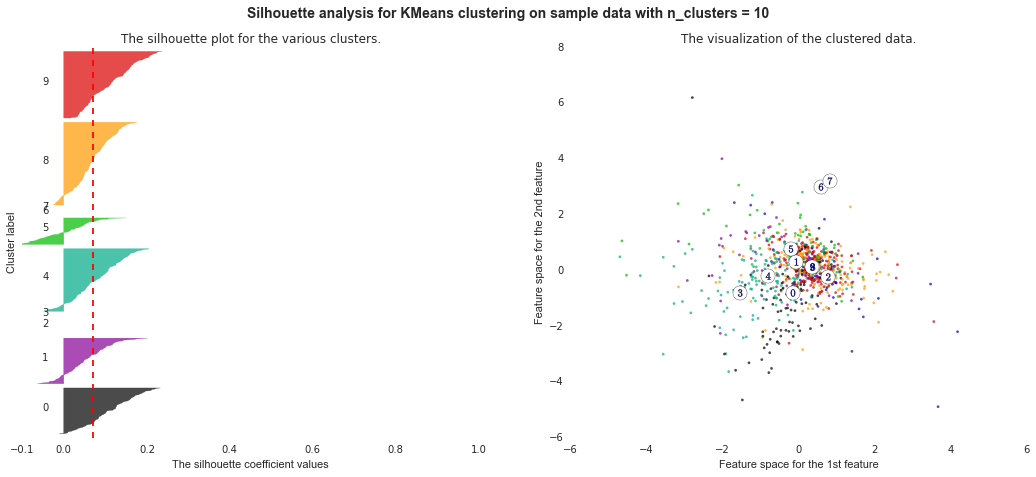

('For n_clusters =', 11, 'The average silhouette_score is :', 0.07319274000686643)


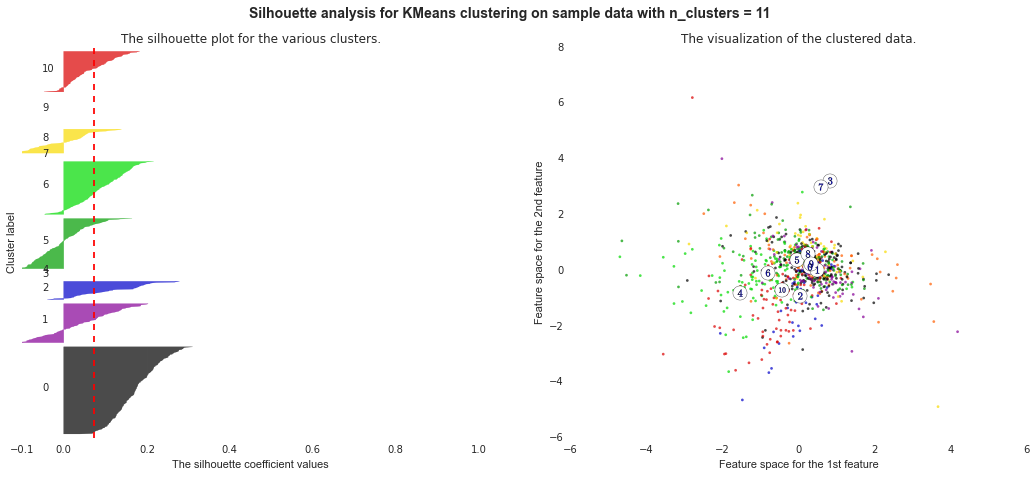

('For n_clusters =', 12, 'The average silhouette_score is :', 0.072653158235381668)


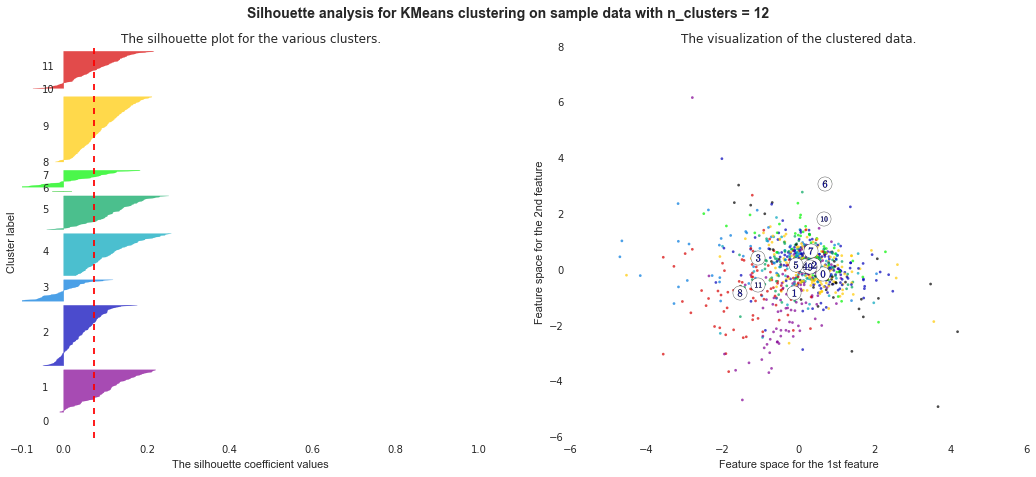

('For n_clusters =', 13, 'The average silhouette_score is :', 0.068152481544979562)


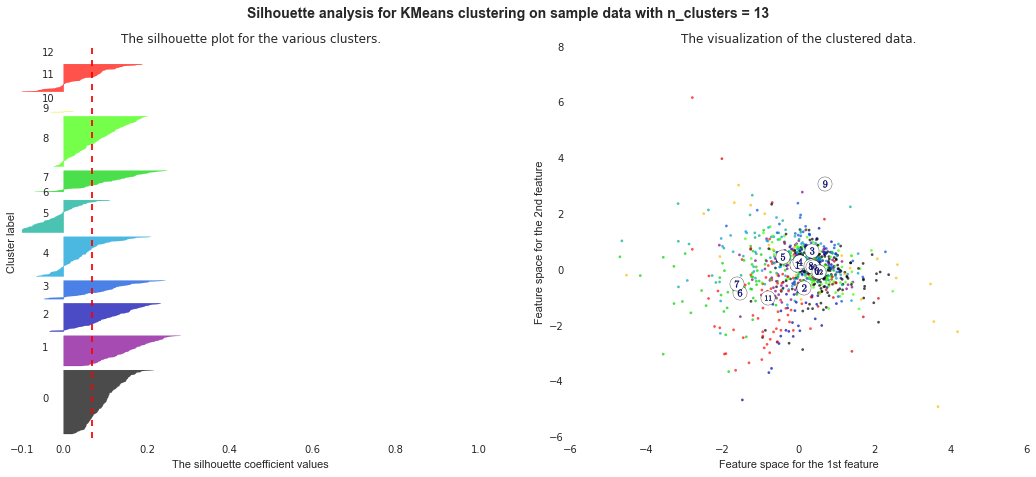

('For n_clusters =', 14, 'The average silhouette_score is :', 0.077661605679133605)


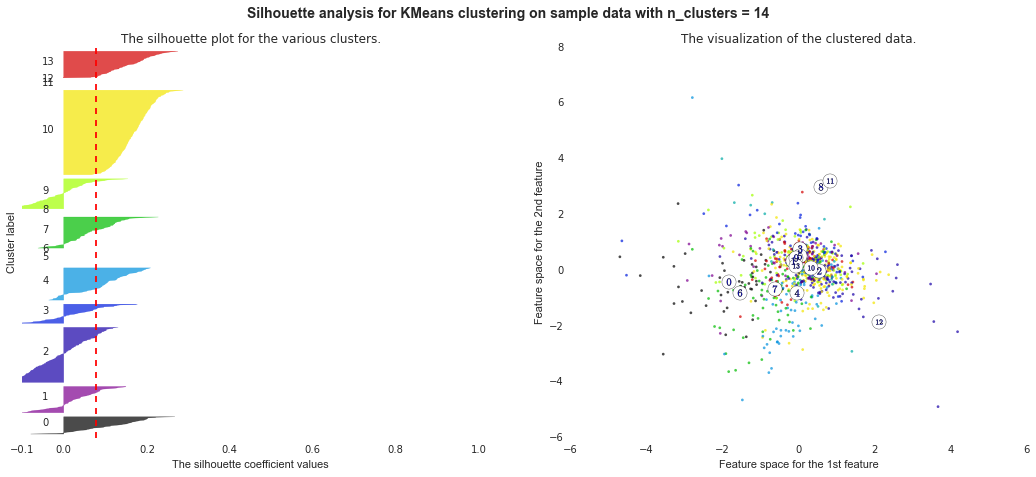

('For n_clusters =', 15, 'The average silhouette_score is :', 0.079724638931321812)


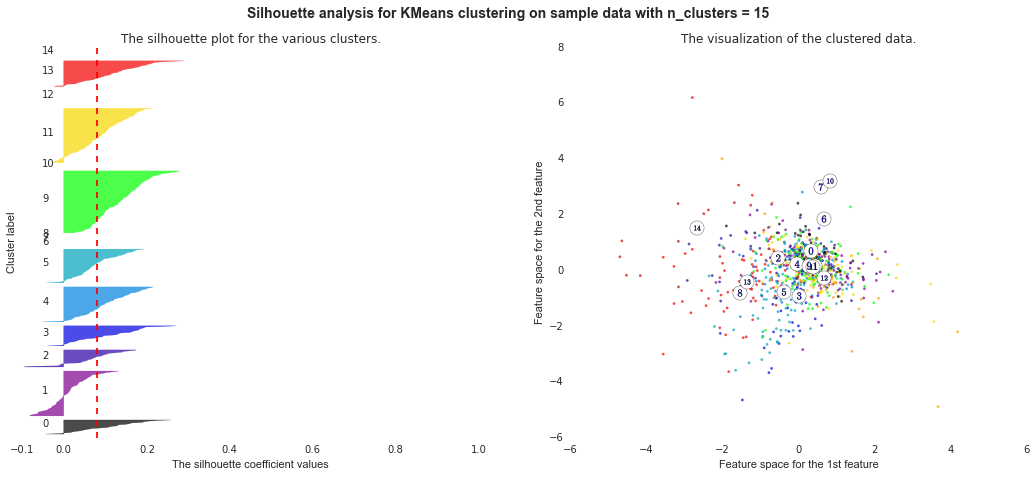

('For n_clusters =', 16, 'The average silhouette_score is :', 0.071926389843996283)


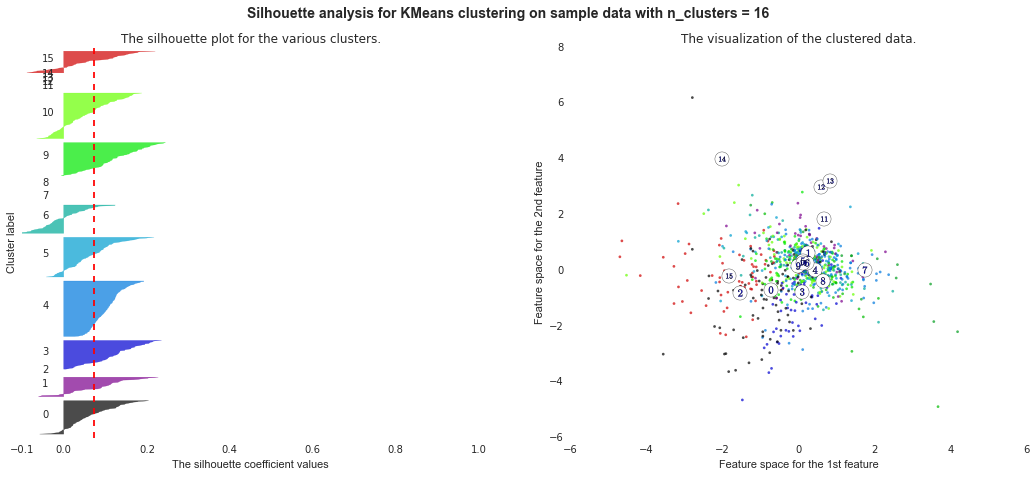

('For n_clusters =', 17, 'The average silhouette_score is :', 0.064898569797656055)


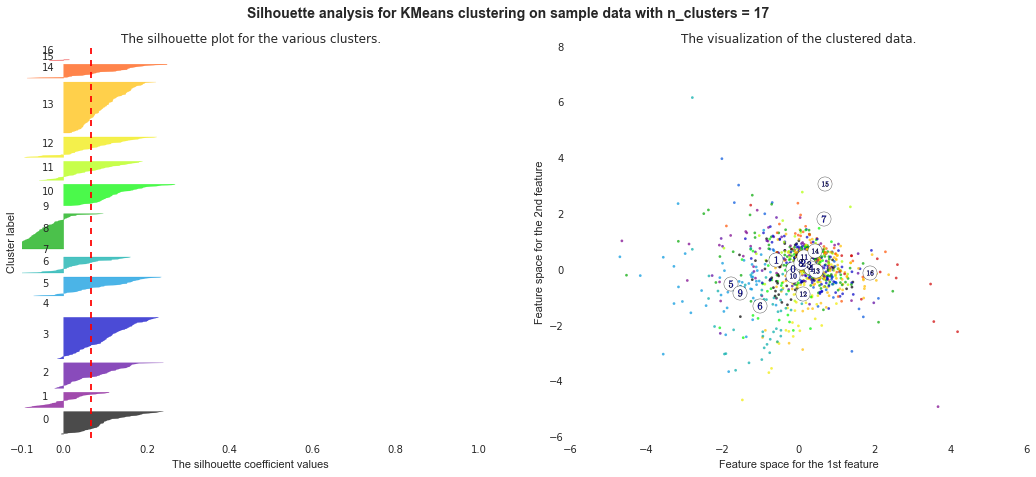

('For n_clusters =', 18, 'The average silhouette_score is :', 0.076726368348248961)


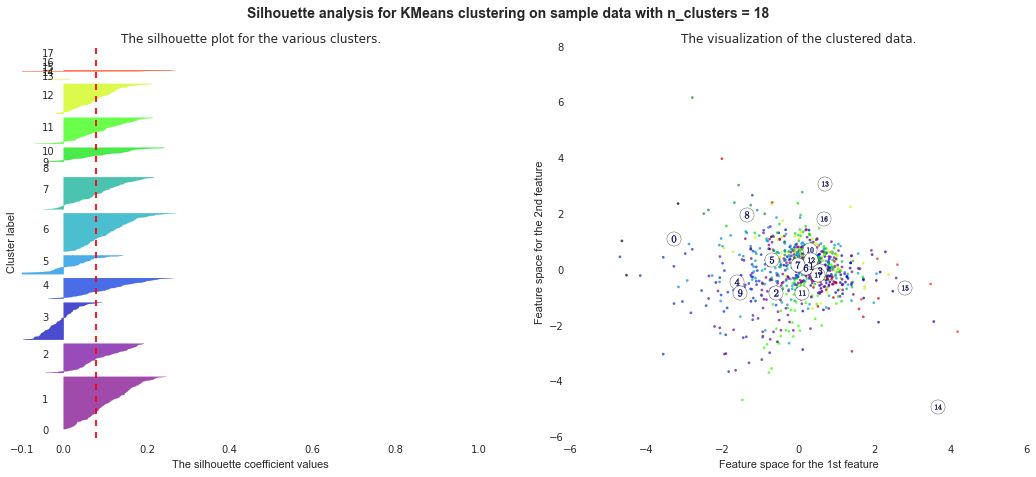

('For n_clusters =', 19, 'The average silhouette_score is :', 0.06356660136418843)


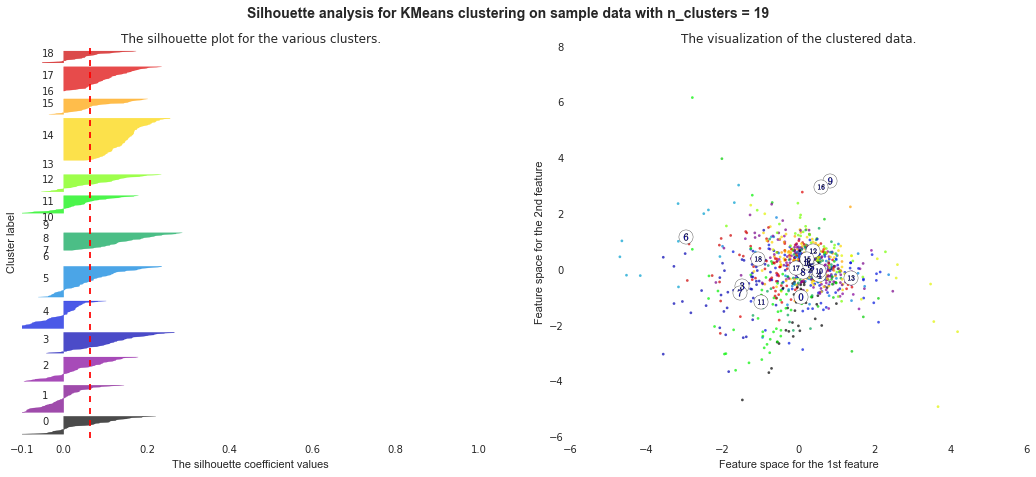

('For n_clusters =', 20, 'The average silhouette_score is :', 0.069883115776828583)


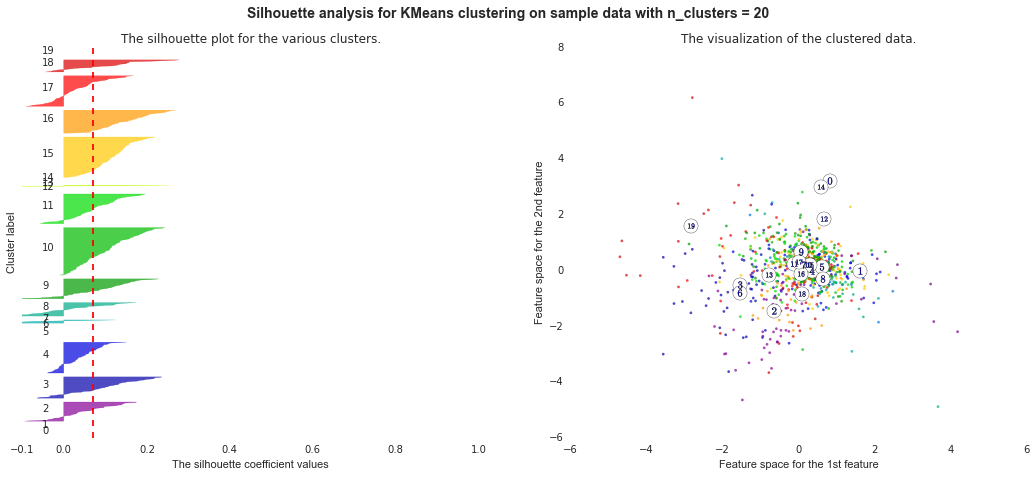

In [118]:
import matplotlib.cm as cm
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(cluster_array) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(cluster_array)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(cluster_array, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(cluster_array, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(cluster_array[:, 0], cluster_array[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')


    file_name = 'clusters_' + str(n_clusters) + '.png'
    plt.savefig(file_name)
    plt.show()

In [107]:

range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
for n_clusters in range_n_clusters:

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(cluster_array)

    silhouette_avg = silhouette_score(cluster_array, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    

('For n_clusters =', 2, 'The average silhouette_score is :', 0.11456797793677613)
('For n_clusters =', 3, 'The average silhouette_score is :', 0.10355011636433725)
('For n_clusters =', 4, 'The average silhouette_score is :', 0.084087533557380911)
('For n_clusters =', 5, 'The average silhouette_score is :', 0.094443718316425618)
('For n_clusters =', 6, 'The average silhouette_score is :', 0.093579521463489787)
('For n_clusters =', 7, 'The average silhouette_score is :', 0.074362864351435659)
('For n_clusters =', 8, 'The average silhouette_score is :', 0.070823419236981391)
('For n_clusters =', 9, 'The average silhouette_score is :', 0.066891499811715716)
('For n_clusters =', 10, 'The average silhouette_score is :', 0.07003300569056696)
('For n_clusters =', 11, 'The average silhouette_score is :', 0.07319274000686643)
('For n_clusters =', 12, 'The average silhouette_score is :', 0.072653158235381668)
('For n_clusters =', 13, 'The average silhouette_score is :', 0.068152481544979562)
('Fo

In [108]:
num_clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
slihouette_scores =[0.114567978,0.103550116,0.084087534,0.094443718,0.093579521,0.074362864,0.070823419,0.0668915,0.070033006,0.07319274,0.072653158,0.068152482,0.077661606,0.079724639,0.07192639,0.06489857,0.076726368,0.063566601,0.069883116]


(0, 0.15)

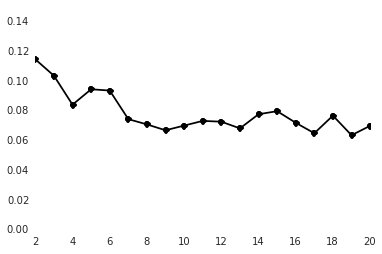

In [116]:
import seaborn
plt.plot(num_clusters,slihouette_scores,'k',marker = 'o')
plt.ylim((0,0.15))